# Predict future return by Neural Network

# Implementation remarks:
* This setting Inspired by a famous kaggle repository about predicting the NY stock price
* Neural Networks based techniques are strong tools for machine learning, however, the hardest thing is tuning it to the right parameters
* In this implementation, I had run multiple times and selected the best features for all technique
    * Dropped features : Sales, close return, hi/lo
* These models are trained on Graphic Cards nVidia GTX 1050i 4G
* See more at : https://skymind.ai/wiki/lstm and https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru


In [1]:
import numpy as np
import pandas as pd
import pickle
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from numba import cuda

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 


In [2]:
with open(r"full_df.pickle", "rb") as input_file:
    df = pickle.load(input_file)

In [3]:
df.head()

,ticker,open,high,low,close,volume,close_return,future_return,hi_lo,hi-lo,sales
date,,,,,,,,,,,
2015-01-02,AAA,50.10,50.11,50.09,50.11,409863,NaN,0.000000,1.000399,0.02,2.053619e+07
2015-01-05,AAA,50.11,50.11,50.09,50.11,35205,0.0000,0.000000,1.000399,0.02,1.764123e+06
2015-01-06,AAA,50.11,50.12,50.11,50.11,11138,0.0000,0.000200,1.000200,0.01,5.581252e+05
2015-01-07,AAA,50.10,50.12,50.10,50.12,27378,0.0002,0.000000,1.000399,0.02,1.371912e+06
2015-01-08,AAA,50.13,50.13,50.11,50.12,20046,0.0000,0.000399,1.000399,0.02,1.004806e+06


In [4]:
idx = 123
selected_stock = df.ticker.unique()[idx                           ]
selected_stock

'REA'

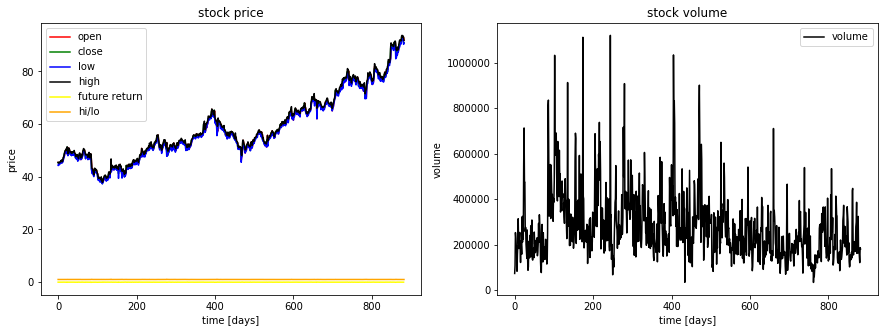

In [5]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.ticker == selected_stock].open.values, color='red', label='open')
plt.plot(df[df.ticker == selected_stock].close.values, color='green', label='close')
plt.plot(df[df.ticker == selected_stock].low.values, color='blue', label='low')
plt.plot(df[df.ticker == selected_stock].high.values, color='black', label='high')
plt.plot(df[df.ticker == selected_stock].future_return.values, color='yellow', label='future return')
plt.plot(df[df.ticker == selected_stock].hi_lo.values, color='orange', label='hi/lo')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.ticker == selected_stock].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best')

In [6]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1,1))
    df['close_return'] = min_max_scaler.fit_transform(df['close_return'].values.reshape(-1,1))
    df['future_return'] = min_max_scaler.fit_transform(df['future_return'].values.reshape(-1,1))
    df['hi_lo'] = min_max_scaler.fit_transform(df['hi_lo'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df[df.ticker == selected_stock].copy()
df_stock.drop(['ticker'],1,inplace=True)


cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)
# df_stock_norm.drop(['volume'],1,inplace=True)
df_stock_norm.drop(['close_return'],1,inplace=True)
# df_stock_norm.drop(['future_return'],1,inplace=True)
df_stock_norm.drop(['hi_lo'],1,inplace=True)
df_stock_norm.drop(['sales'],1,inplace=True)


# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'high', 'low', 'close', 'volume', 'close_return', 'future_return', 'hi_lo', 'hi-lo', 'sales']
x_train.shape =  (691, 19, 7)
y_train.shape =  (691, 7)
x_valid.shape =  (86, 19, 7)
y_valid.shape =  (86, 7)
x_test.shape =  (86, 19, 7)
y_test.shape =  (86, 7)


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


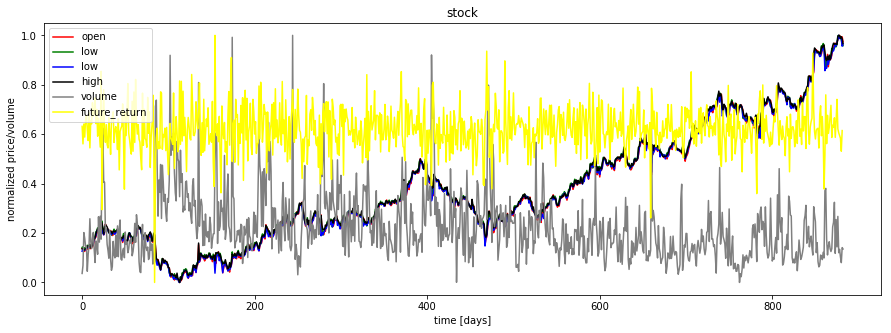

In [7]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.plot(df_stock_norm['future_return'].values, color='yellow', label='future_return')
# plt.plot(df_stock_norm['hi_lo'].values, color='purple', label='hi_lo')
# plt.plot(df_stock_norm['sales'].values, color='orange', label='sales')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [8]:
df_stock_norm.head()

,open,high,low,close,volume,future_return,hi-lo
date,,,,,,,
2015-01-02,0.137004,0.136355,0.126219,0.141935,0.036358,0.631766,1.18
2015-01-05,0.135199,0.136355,0.137053,0.144086,0.068609,0.560768,0.58
2015-01-06,0.129603,0.130980,0.131094,0.136559,0.201802,0.641155,0.61
2015-01-07,0.125632,0.132951,0.129830,0.139964,0.178337,0.588222,0.79
2015-01-08,0.135379,0.137251,0.134706,0.136201,0.147278,0.658415,0.76


* n_steps = seq_len-1 
* n_inputs = 7
* n_neurons = 300
* n_outputs = 7
* n_layers = 5
* learning_rate = 0.0001
* batch_size = 50
* n_epochs = 100 

## GRU cell
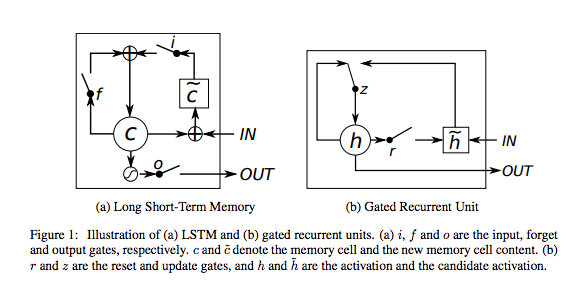


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
0.00 epochs: MSE train/valid = 0.334259/0.613427
4.99 epochs: MSE train/valid = 0.061128/0.087288
9.99 epochs: MSE train/valid = 0.053207/0.049780
14.98 epochs: MSE train/valid = 0.051425/0.048745
19.97 epochs: MSE train/valid = 0.051064/0.048048
24.96 epochs: MSE train/va

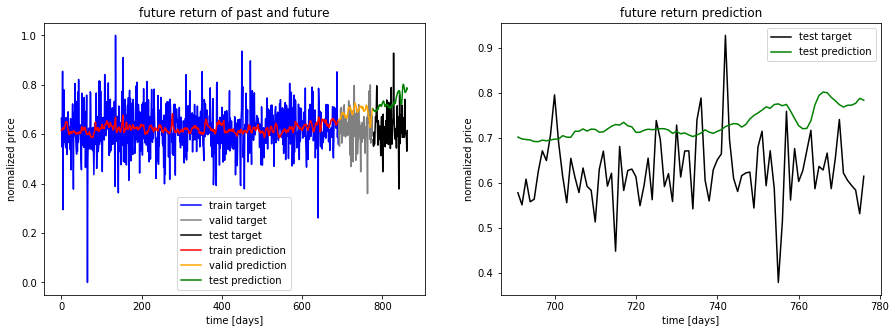

In [9]:


index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

###################################### parameters################################
n_steps = seq_len-1 
n_inputs = 7
n_neurons = 300
n_outputs = 7
n_layers = 5
learning_rate = 0.0001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

###############################################Select type of Neural Network###########################

# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
         for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
    
########################################## plot and benchmark###################################

ft = 5 # 0 = open, 1 = close, 2 = highest, 3 = lowest,4 = volume, 5 = future return, 6 =hi/low

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return of past and future')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
#             np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]


# corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
#             np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
# corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
#             np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
#     corr_price_development_train, corr_price_development_valid, corr_price_development_test))


MSE_train = np.mean((np.square(np.subtract(y_train[:,ft],y_train_pred[:,ft])))) 
MSE_valid = np.mean((np.square(np.subtract(y_valid[:,ft],y_valid_pred[:,ft])))) 
MSE_test = np.mean((np.square(np.subtract(y_test[:,ft],y_test_pred[:,ft])))) 

print('MSE for train/valid/test: %.5f/%.5f/%.5f'%(
    MSE_train, MSE_valid, MSE_test))

###Release GPU memory###
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

Seems we are not there yet! It's seems to be overfitted where MSE for train/valid/test: 0.00865/0.00993/0.01748 
<br>
<br>
Let's try another NN setting - LSTM

## LSTM Cell with peephole connections

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
0.00 epochs: MSE train/valid = 0.351867/0.649399
4.99 epochs: MSE train/valid = 0.063870/0.101836
9.99 epochs: MSE train/valid = 0.058838/0.089266
14.98 epochs: MSE train/valid = 0.056134/0.067493
19.97 epochs: MSE train/valid = 0.052076/0.047261
24.96 epochs: MSE train/valid = 0.051597/0.047935
29.96 epochs: MSE train/valid = 0.051368/0.047316
34.95 epochs: MSE train/valid = 0.051093/0.047873
39.94 epochs: MSE train/valid = 0.051090/0.047803
44.93 epochs: MSE train/valid = 0.051427/0.050742
49.93 epochs: MSE train/valid = 0.051278/0.047814
54.92 epochs: MSE train/valid = 0.051213/0.049906
59.91 epochs: MSE train/valid = 0.050562/0.048766
64.91 epochs: MSE train/valid = 0.051263/0.053099
69.90 epochs: MSE train/valid = 0.050511/0.048483
74.89 epochs: MSE train/valid = 0.051684/0.062149
79.88 epochs: MSE train/valid = 0.050441/0.049807
84.88 epochs: MSE train/

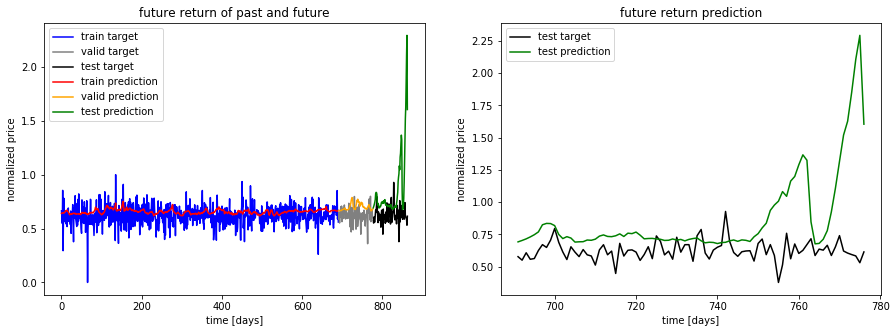

In [10]:


index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

###################################### parameters################################
n_steps = seq_len-1 
n_inputs = 7
n_neurons = 300
n_outputs = 7
n_layers = 5
learning_rate = 0.0001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
""
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])


#### ##########################################Select type of Neural Network###########################

# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                 activation=tf.nn.leaky_relu, use_peepholes = True)
         for layer in range(n_layers)]

# use GRU cell
# layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
    
#### plot and benchmark###


ft = 5 # 0 = open, 1 = close, 2 = highest, 3 = lowest,4 = volume, 5 = future return, 6 =hi/low

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return of past and future')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
#             np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]


# corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
#             np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
# corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
#             np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
#     corr_price_development_train, corr_price_development_valid, corr_price_development_test))


MSE_train = np.mean((np.square(np.subtract(y_train[:,ft],y_train_pred[:,ft])))) 
MSE_valid = np.mean((np.square(np.subtract(y_valid[:,ft],y_valid_pred[:,ft])))) 
MSE_test = np.mean((np.square(np.subtract(y_test[:,ft],y_test_pred[:,ft])))) 

print('MSE for train/valid/test: %.5f/%.5f/%.5f'%(
    MSE_train, MSE_valid, MSE_test))

This one even worse than the previous one, it's over fitting ,Try the normal LSTM

## LSTM cell
the figure below illustrates what happen in a LSTM cell
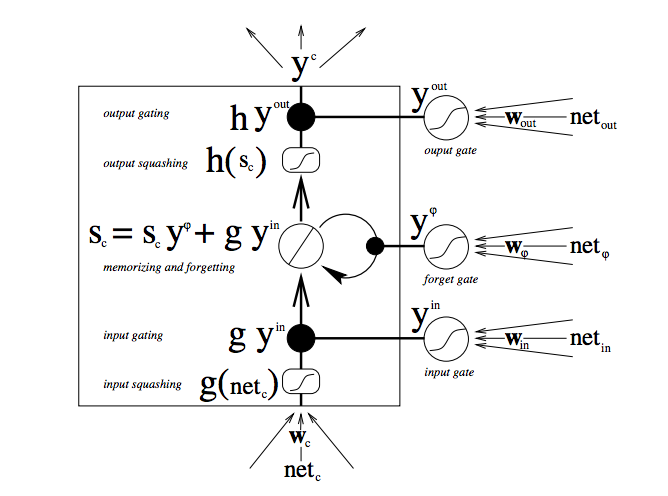

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
0.00 epochs: MSE train/valid = 0.341210/0.634642
4.99 epochs: MSE train/valid = 0.057808/0.083724
9.99 epochs: MSE train/valid = 0.052816/0.047456
14.98 epochs: MSE train/valid = 0.051584/0.047981
19.97 epochs: MSE train/valid = 0.051877/0.050400
24.96 epochs: MSE train/valid = 0.051470/0.049039
29.96 epochs: MSE train/valid = 0.051428/0.049439
34.95 epochs: MSE train/valid = 0.051638/0.048593
39.94 epochs: MSE train/valid = 0.051298/0.048354
44.93 epochs: MSE train/valid = 0.051293/0.047140
49.93 epochs: MSE train/valid = 0.051215/0.050227
54.92 epochs: MSE train/valid = 0.051209/0.048286
59.91 epochs: MSE train/valid = 0.051283/0.047055
64.91 epochs: MSE train/valid = 0.051544/0.046962
69.90 epochs: MSE train/valid = 0.051151/0.047590
74.89 epochs: MSE train/valid = 0.051085/0.050353
79.88 epochs: MSE train/valid = 0.051782/0.053334
84.88 epochs: MSE train/

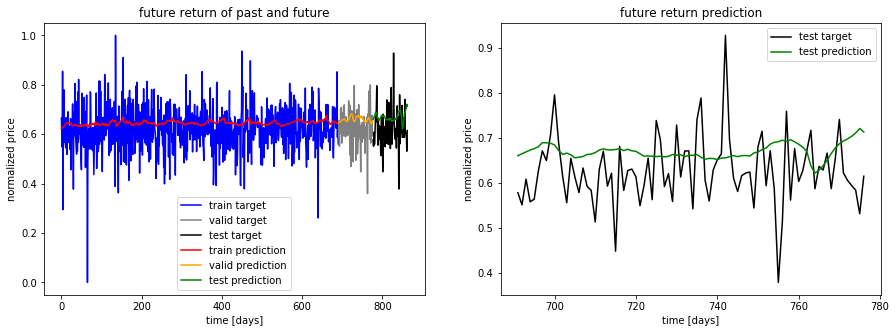

In [11]:

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

###################################### parameters################################
n_steps = seq_len-1 
n_inputs = 7
n_neurons = 300
n_outputs = 7
n_layers = 5
learning_rate = 0.0001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
""
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])


#### ##########################################Select type of Neural Network###########################
# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]

# use LSTM Cell with peephole connections
# layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
# layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
    
#################################################### plot and benchmark#############################


ft = 5 # 0 = open, 1 = close, 2 = highest, 3 = lowest,4 = volume, 5 = future return, 6 =hi/low

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return of past and future')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
#             np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]


# corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
#             np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
# corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
#             np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
#     corr_price_development_train, corr_price_development_valid, corr_price_development_test))


MSE_train = np.mean((np.square(np.subtract(y_train[:,ft],y_train_pred[:,ft])))) 
MSE_valid = np.mean((np.square(np.subtract(y_valid[:,ft],y_valid_pred[:,ft])))) 
MSE_test = np.mean((np.square(np.subtract(y_test[:,ft],y_test_pred[:,ft])))) 

print('MSE for train/valid/test: %.5f/%.5f/%.5f'%(
    MSE_train, MSE_valid, MSE_test))

LSTM seems fine, it's not over fitting but we are not there yet (see the plot)

## RNN cell
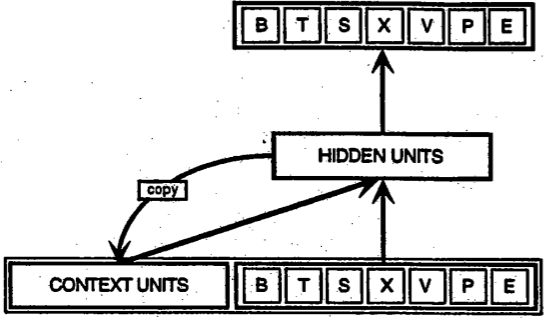

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
0.00 epochs: MSE train/valid = 0.157682/0.232172
4.99 epochs: MSE train/valid = 0.051586/0.059653
9.99 epochs: MSE train/valid = 0.047291/0.056650
14.98 epochs: MSE train/valid = 0.044359/0.056597
19.97 epochs: MSE train/valid = 0.043040/0.054460
24.96 epochs: MSE train/valid = 0.041010/0.054571
29.96 epochs: MSE train/valid = 0.039612/0.059638
34.95 epochs: MSE train/valid = 0.038457/0.058670
39.94 epochs: MSE train/valid = 0.039676/0.063515
44.93 epochs: MSE train/valid = 0.035042/0.059376
49.93 epochs: MSE train/valid = 0.035115/0.064888
54.92 epochs: MSE train/valid = 0.032001/0.064437
59.91 epochs: MSE train/valid = 0.031855/0.063709
64.91 epochs: MSE train/valid = 0.029213/0.062933
69.90 epochs: MSE train/valid = 0.030168/0.083243
74.89 epochs: MSE train/valid = 0.027862/0.071875
79.88 epochs: MSE train/valid = 0.026167/0.076371
84.88 epochs: MSE t

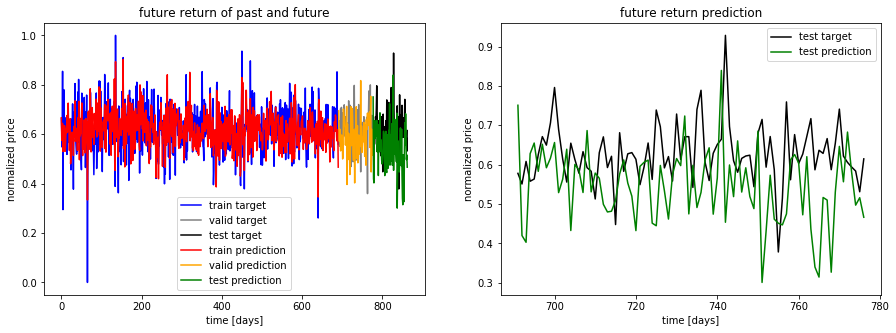

In [12]:
# Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 7
n_neurons = 300
n_outputs = 7
n_layers = 5
learning_rate = 0.0001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
""
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])


#### ##########################################Select type of Neural Network###########################
# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
# layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
# layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
# layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]




multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
    
############################################# plot and benchmark###############################


ft = 5 # 0 = open, 1 = close, 2 = highest, 3 = lowest,4 = volume, 5 = future return, 6 =hi/low

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return of past and future')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future return prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
#             np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]


# corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
#             np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
# corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
#             np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
#     corr_price_development_train, corr_price_development_valid, corr_price_development_test))


MSE_train = np.mean((np.square(np.subtract(y_train[:,ft],y_train_pred[:,ft])))) 
MSE_valid = np.mean((np.square(np.subtract(y_valid[:,ft],y_valid_pred[:,ft])))) 
MSE_test = np.mean((np.square(np.subtract(y_test[:,ft],y_test_pred[:,ft])))) 

print('MSE for train/valid/test: %.5f/%.5f/%.5f'%(
    MSE_train, MSE_valid, MSE_test))

###Release GPU memory###
from numba import cuda
cuda.select_device(0)
cuda.close()

## Winner : RNN